In [1]:
# Installation des bibliothèques nécessaires
!pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, roc_curve, auc)

# Algorithmes de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Projet : Classification du Diabète

**Objectif :** Prédire si un patient est diabétique en fonction de plusieurs mesures médicales.

**Dataset :** Pima Indians Diabetes Database.

In [3]:
# Chargement du dataset
df = pd.read_csv('diabetes.csv')

# Affichage des premières lignes du dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Analyse Exploratoire des Données (EDA)

In [4]:
# Dimensions du dataset
print(f"Le dataset contient {df.shape[0]} lignes et {df.shape[1]} colonnes.")

Le dataset contient 768 lignes et 9 colonnes.


In [5]:
# Informations sur les données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# Statistiques descriptives
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Distribution de la variable cible

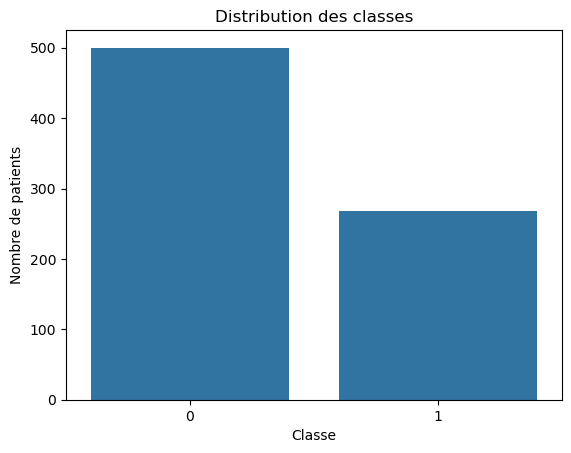

In [7]:
# Distribution de la variable cible
sns.countplot(x='Outcome', data=df)
plt.title('Distribution des classes')
plt.xlabel('Classe')
plt.ylabel('Nombre de patients')
plt.show()

In [8]:
# Nombre de cas pour chaque classe
print(df['Outcome'].value_counts())

Outcome
0    500
1    268
Name: count, dtype: int64


**Observation :**
- Le dataset est déséquilibré avec 500 patients non diabétiques et 268 diabétiques.
- Ce déséquilibre pourrait influencer les performances des modèles et sera pris en compte lors de l'évaluation.

### Analyse des variables indépendantes

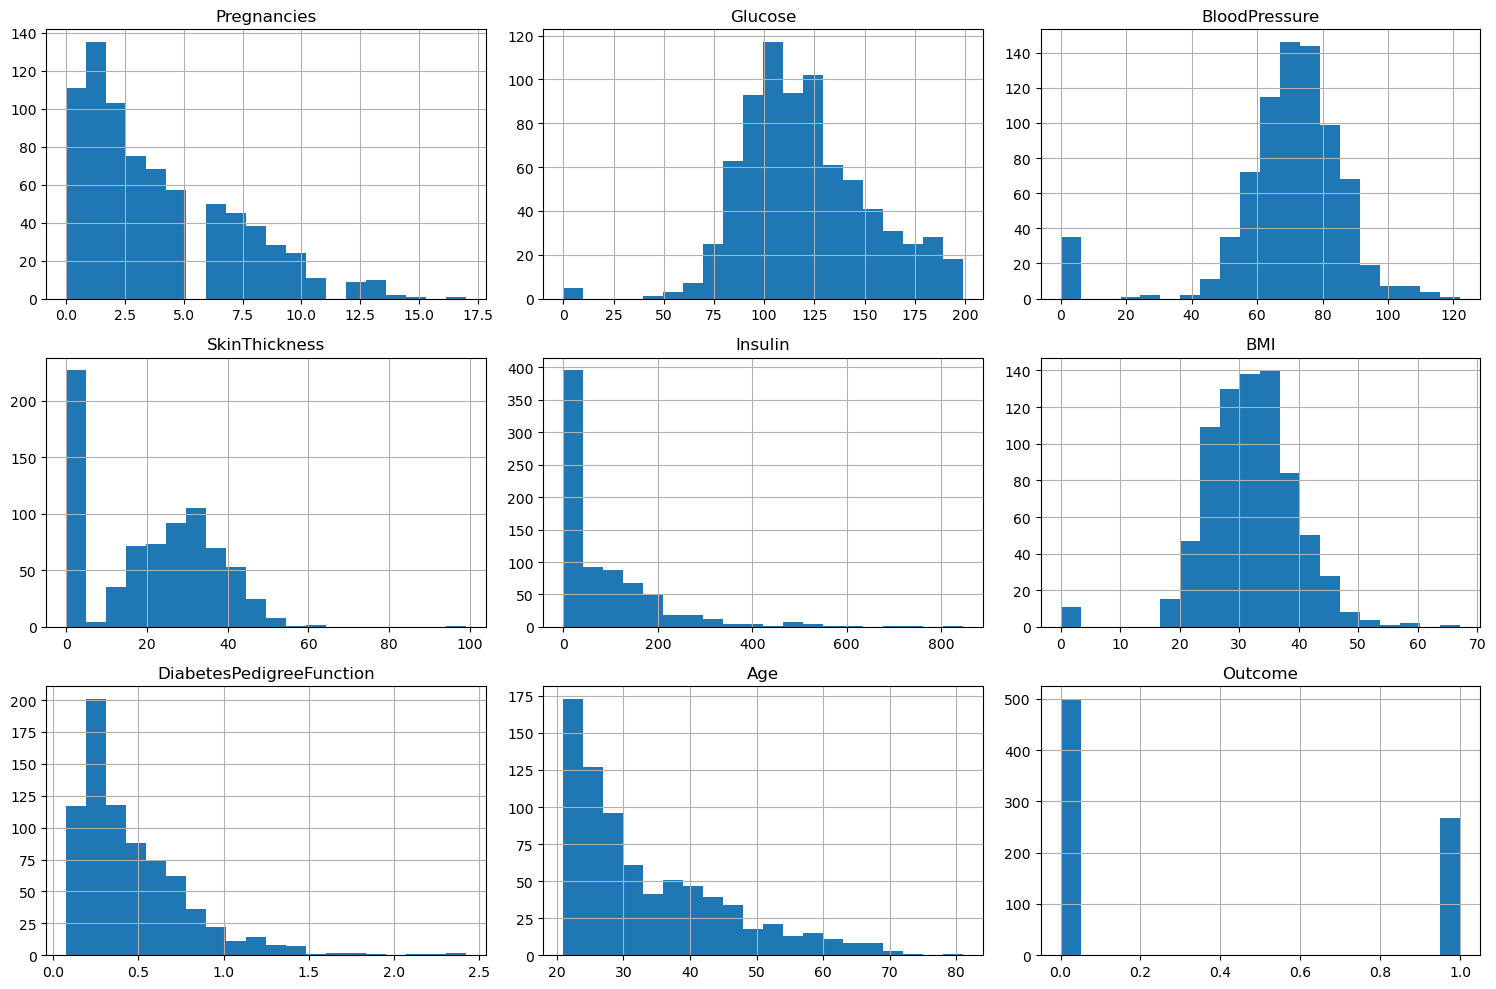

In [9]:
# Histogrammes des variables
df.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

**Observation :**
- Certaines variables comme 'Insulin' et 'SkinThickness' présentent une distribution asymétrique.
- Il y a des valeurs nulles représentées par des zéros dans certaines colonnes.

## Prétraitement des Données

### Gestion des valeurs manquantes

In [10]:
# Identifier les colonnes avec des valeurs zéro impossibles
colonnes_a_corriger = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Remplacer les zéros par NaN
df[colonnes_a_corriger] = df[colonnes_a_corriger].replace(0, np.nan)

# Vérifier les valeurs manquantes
print(df.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [11]:
# Imputer les valeurs manquantes avec la médiane
df[colonnes_a_corriger] = df[colonnes_a_corriger].fillna(df[colonnes_a_corriger].median())

# Vérifier s'il reste des valeurs manquantes
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


**Justification :**
- L'imputation avec la médiane est choisie pour réduire l'influence des valeurs extrêmes.
- Cela permet de conserver la distribution des données sans introduire de biais significatif.

### Vérification des valeurs aberrantes

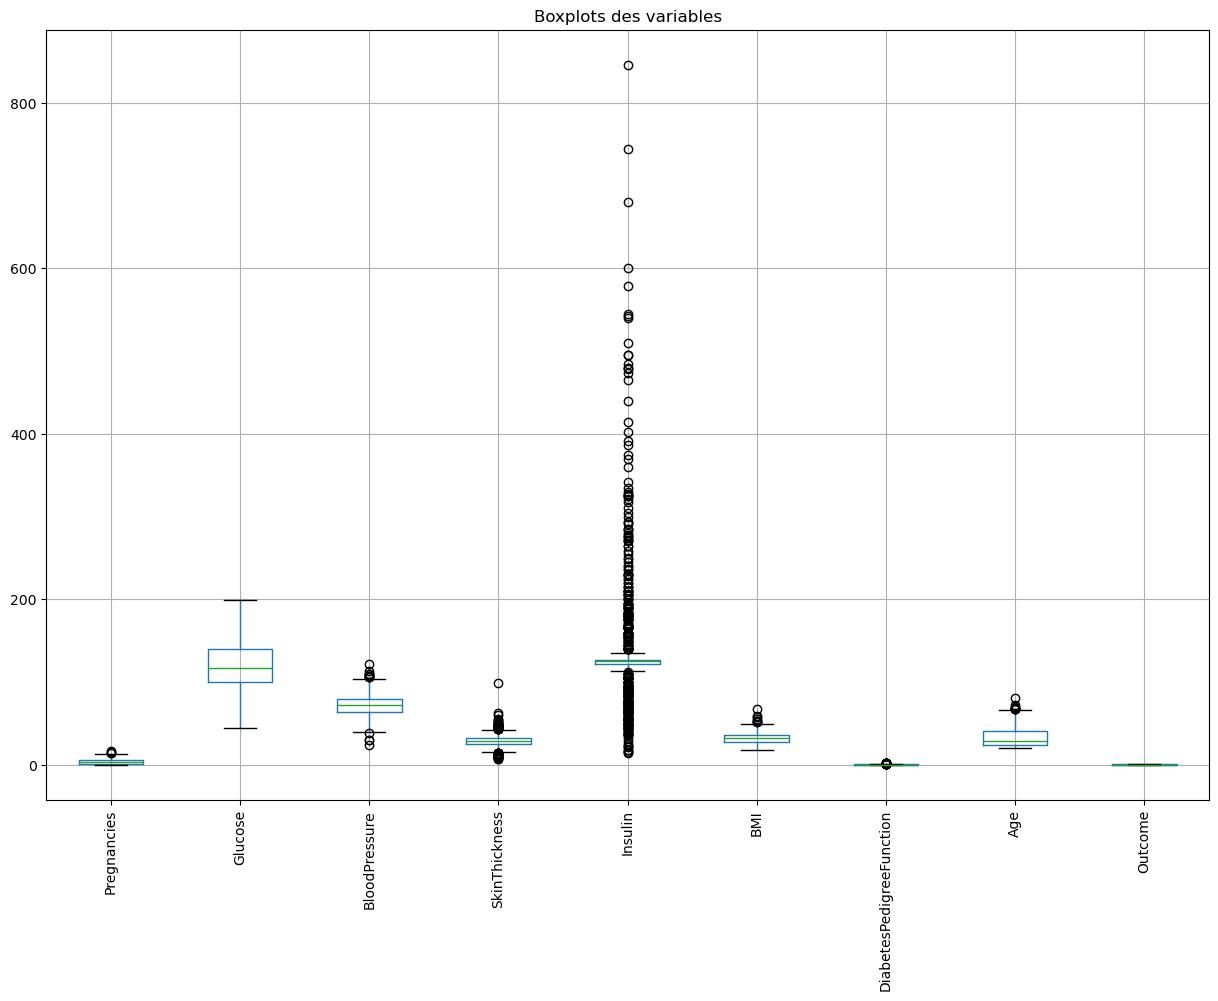

In [12]:
# Afficher les boxplots pour détecter les outliers
plt.figure(figsize=(15, 10))
df.boxplot()
plt.title('Boxplots des variables')
plt.xticks(rotation=90)
plt.show()

**Observation :**
- Les variables 'Insulin', 'SkinThickness' et 'Pregnancies' présentent des valeurs aberrantes.
- Les modèles robustes comme l'Arbre de Décision peuvent gérer ces outliers.

### Analyse des corrélations

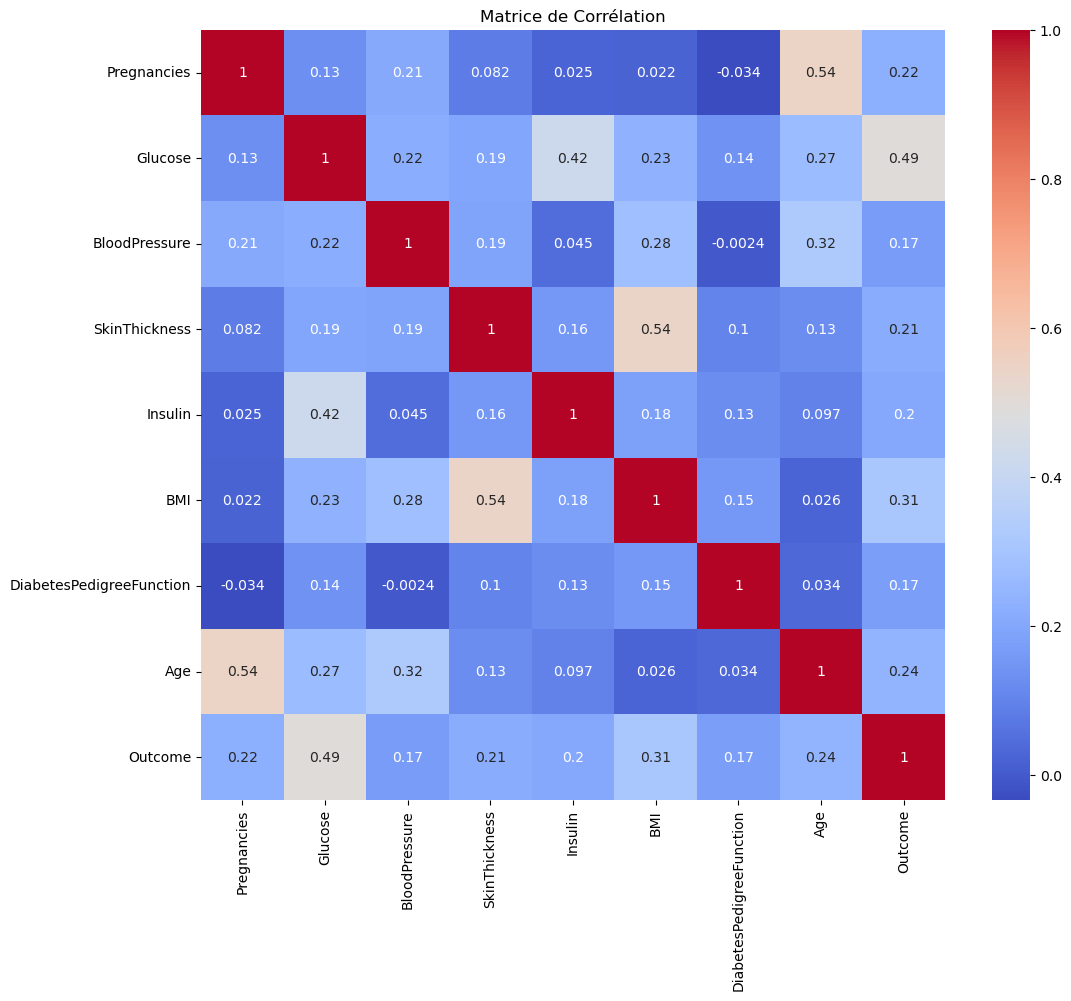

In [13]:
# Matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation')
plt.show()

**Observation :**
- 'Glucose' a une forte corrélation positive avec l'Outcome.
- 'BMI' et 'Age' montrent également une corrélation positive significative.
- Peu de corrélation entre les variables indépendantes, ce qui réduit le risque de multicolinéarité.

## Séparation des Données

In [14]:
# Séparer les features et la target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [15]:
# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# Division en ensembles d'entraînement et de test avec stratification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

**Justification :**
- La stratification assure que la proportion des classes est maintenue dans les ensembles d'entraînement et de test.
- Cela est important pour obtenir une évaluation réaliste des performances des modèles.

## Entraînement des Modèles

### Régression Logistique

In [17]:
# Instanciation du modèle
lr = LogisticRegression(max_iter=1000)

# Entraînement du modèle
lr.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_lr = lr.predict(X_test)

### Arbre de Décision

In [18]:
# Instanciation du modèle
dt = DecisionTreeClassifier(random_state=42)

# Entraînement du modèle
dt.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_dt = dt.predict(X_test)

### Réseau de Neurones

In [19]:
# Instanciation du modèle
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Entraînement du modèle
mlp.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_mlp = mlp.predict(X_test)

## Évaluation des Modèles

In [36]:
# Fonction pour afficher les métriques
def afficher_metrics(y_test, y_pred, model_name, filename=None):
    print(f"Performance du modèle : {model_name}")
    print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
    print("Precision :", round(precision_score(y_test, y_pred), 4))
    print("Recall :", round(recall_score(y_test, y_pred), 4))
    print("F1-Score :", round(f1_score(y_test, y_pred), 4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.ylabel('Vraies Valeurs')
    plt.xlabel('Prédictions')
    if filename:
        plt.savefig(filename)
    plt.show()

Performance du modèle : Régression Logistique
Accuracy : 0.7013
Precision : 0.587
Recall : 0.5
F1-Score : 0.54

Classification Report:
               precision    recall  f1-score   support

           0     0.7500    0.8100    0.7788       100
           1     0.5870    0.5000    0.5400        54

    accuracy                         0.7013       154
   macro avg     0.6685    0.6550    0.6594       154
weighted avg     0.6928    0.7013    0.6951       154



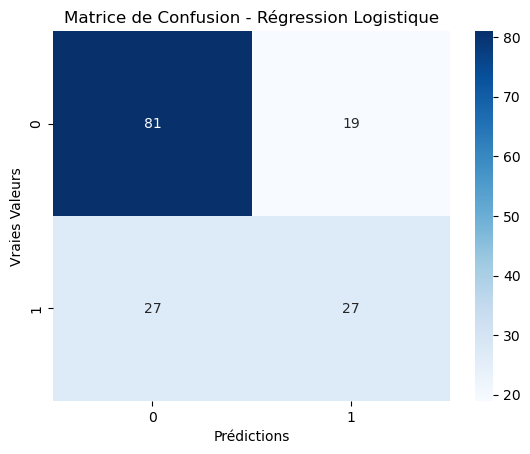

In [21]:
# Évaluation de la Régression Logistique
afficher_metrics(y_test, y_pred_lr, "Régression Logistique")

Performance du modèle : Arbre de Décision
Accuracy : 0.6818
Precision : 0.5532
Recall : 0.4815
F1-Score : 0.5149

Classification Report:
               precision    recall  f1-score   support

           0     0.7383    0.7900    0.7633       100
           1     0.5532    0.4815    0.5149        54

    accuracy                         0.6818       154
   macro avg     0.6458    0.6357    0.6391       154
weighted avg     0.6734    0.6818    0.6762       154



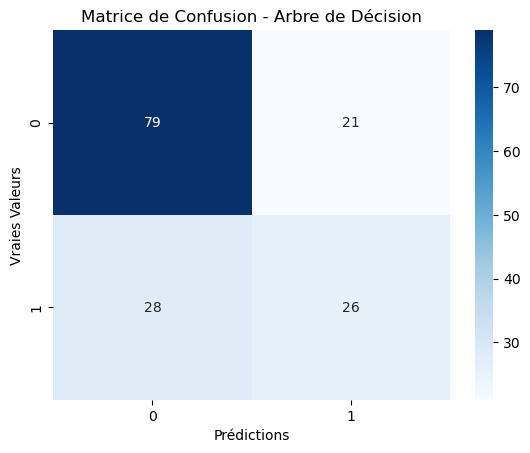

In [22]:
# Évaluation de l'Arbre de Décision
afficher_metrics(y_test, y_pred_dt, "Arbre de Décision")

Performance du modèle : Réseau de Neurones
Accuracy : 0.7468
Precision : 0.6744
Recall : 0.537
F1-Score : 0.5979

Classification Report:
               precision    recall  f1-score   support

           0     0.7748    0.8600    0.8152       100
           1     0.6744    0.5370    0.5979        54

    accuracy                         0.7468       154
   macro avg     0.7246    0.6985    0.7066       154
weighted avg     0.7396    0.7468    0.7390       154



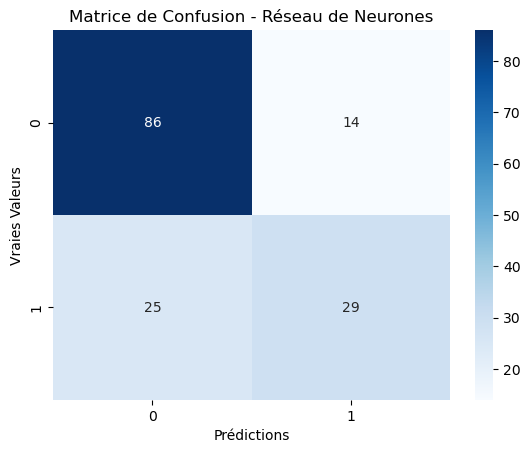

In [23]:
# Évaluation du Réseau de Neurones
afficher_metrics(y_test, y_pred_mlp, "Réseau de Neurones")

## Comparaison des Modèles

In [24]:
# Stocker les métriques dans un dataframe
models = ['Régression Logistique', 'Arbre de Décision', 'Réseau de Neurones']
accuracy = [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_mlp)]
precision = [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_dt), precision_score(y_test, y_pred_mlp)]
recall = [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_dt), recall_score(y_test, y_pred_mlp)]
f1 = [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_mlp)]

performance_df = pd.DataFrame({
    'Modèle': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

performance_df

,Modèle,Accuracy,Precision,Recall,F1-Score
0,Régression Logistique,0.701299,0.586957,0.500000,0.540000
1,Arbre de Décision,0.681818,0.553191,0.481481,0.514851
2,Réseau de Neurones,0.746753,0.674419,0.537037,0.597938


**Analyse :**
- Le **Réseau de Neurones** offre les meilleures performances globales avec la plus haute accuracy, précision, rappel et F1-score.
- La **Régression Logistique** et l'**Arbre de Décision** ont des performances inférieures.
- Cela suggère que le Réseau de Neurones capture mieux les relations complexes dans les données.

## Optimisation des Hyperparamètres

### Régression Logistique - Grid Search

In [25]:
# Définir la grille de paramètres
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

# Recherche par grille
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='f1')
grid_lr.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres pour la Régression Logistique :", grid_lr.best_params_)

Meilleurs paramètres pour la Régression Logistique : {'C': 0.1, 'solver': 'liblinear'}


Performance du modèle : Régression Logistique Optimisée
Accuracy : 0.7013
Precision : 0.5833
Recall : 0.5185
F1-Score : 0.549

Classification Report:
               precision    recall  f1-score   support

           0     0.7547    0.8000    0.7767       100
           1     0.5833    0.5185    0.5490        54

    accuracy                         0.7013       154
   macro avg     0.6690    0.6593    0.6629       154
weighted avg     0.6946    0.7013    0.6969       154



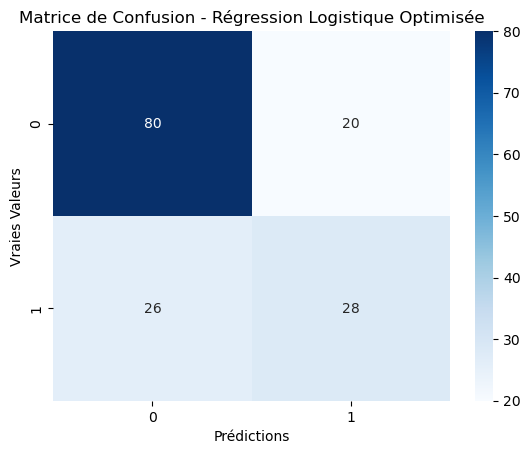

In [26]:
# Prédictions avec le meilleur modèle
best_lr = grid_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test)

# Évaluation
afficher_metrics(y_test, y_pred_best_lr, "Régression Logistique Optimisée")

**Observation :**
- L'optimisation n'a pas apporté de gains significatifs en termes de performances pour la Régression Logistique.

### Arbre de Décision - Grid Search

In [27]:
# Définir la grille de paramètres
param_grid_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Recherche par grille
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='f1')
grid_dt.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres pour l'Arbre de Décision :", grid_dt.best_params_)

Meilleurs paramètres pour l'Arbre de Décision : {'max_depth': None, 'min_samples_split': 2}


Performance du modèle : Arbre de Décision Optimisé
Accuracy : 0.6818
Precision : 0.5532
Recall : 0.4815
F1-Score : 0.5149

Classification Report:
               precision    recall  f1-score   support

           0     0.7383    0.7900    0.7633       100
           1     0.5532    0.4815    0.5149        54

    accuracy                         0.6818       154
   macro avg     0.6458    0.6357    0.6391       154
weighted avg     0.6734    0.6818    0.6762       154



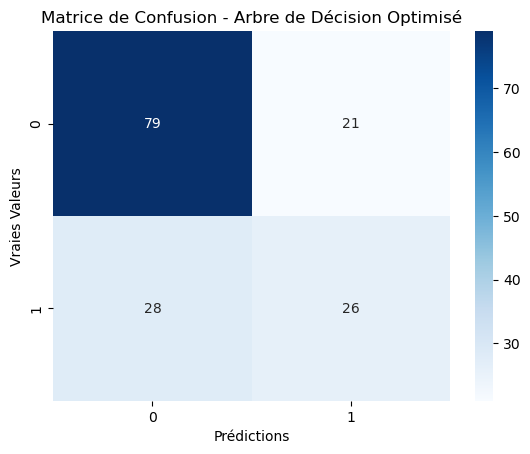

In [28]:
# Prédictions avec le meilleur modèle
best_dt = grid_dt.best_estimator_
y_pred_best_dt = best_dt.predict(X_test)

# Évaluation
afficher_metrics(y_test, y_pred_best_dt, "Arbre de Décision Optimisé")

**Observation :**
- L'optimisation n'a pas amélioré les performances de l'Arbre de Décision de manière significative.

### Réseau de Neurones - Grid Search

In [29]:
# Définir la grille de paramètres
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100,50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd']
}

# Recherche par grille
grid_mlp = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42), param_grid_mlp, cv=3, scoring='f1')
grid_mlp.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres pour le Réseau de Neurones :", grid_mlp.best_params_)

Meilleurs paramètres pour le Réseau de Neurones : {'activation': 'tanh', 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}


Performance du modèle : Réseau de Neurones Optimisé
Accuracy : 0.7403
Precision : 0.6346
Recall : 0.6111
F1-Score : 0.6226

Classification Report:
               precision    recall  f1-score   support

           0     0.7941    0.8100    0.8020       100
           1     0.6346    0.6111    0.6226        54

    accuracy                         0.7403       154
   macro avg     0.7144    0.7106    0.7123       154
weighted avg     0.7382    0.7403    0.7391       154



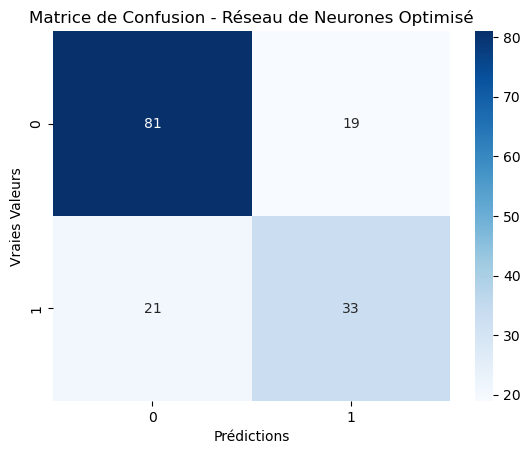

In [30]:
# Prédictions avec le meilleur modèle
best_mlp = grid_mlp.best_estimator_
y_pred_best_mlp = best_mlp.predict(X_test)

# Évaluation
afficher_metrics(y_test, y_pred_best_mlp, "Réseau de Neurones Optimisé")

**Observation :**
- L'optimisation du Réseau de Neurones a amélioré le rappel et le F1-score, tout en maintenant une bonne précision.

## Nouvelle Comparaison des Modèles Optimisés

In [31]:
# Mettre à jour les métriques
accuracy_best = [accuracy_score(y_test, y_pred_best_lr), accuracy_score(y_test, y_pred_best_dt), accuracy_score(y_test, y_pred_best_mlp)]
precision_best = [precision_score(y_test, y_pred_best_lr), precision_score(y_test, y_pred_best_dt), precision_score(y_test, y_pred_best_mlp)]
recall_best = [recall_score(y_test, y_pred_best_lr), recall_score(y_test, y_pred_best_dt), recall_score(y_test, y_pred_best_mlp)]
f1_best = [f1_score(y_test, y_pred_best_lr), f1_score(y_test, y_pred_best_dt), f1_score(y_test, y_pred_best_mlp)]

performance_best_df = pd.DataFrame({
    'Modèle Optimisé': models,
    'Accuracy': accuracy_best,
    'Precision': precision_best,
    'Recall': recall_best,
    'F1-Score': f1_best
})

performance_best_df

,Modèle Optimisé,Accuracy,Precision,Recall,F1-Score
0,Régression Logistique,0.701299,0.583333,0.518519,0.549020
1,Arbre de Décision,0.681818,0.553191,0.481481,0.514851
2,Réseau de Neurones,0.740260,0.634615,0.611111,0.622642


**Analyse :**
- Après optimisation, le **Réseau de Neurones** affiche les meilleures performances globales.
- Le rappel du Réseau de Neurones a augmenté, ce qui est crucial pour détecter les patients diabétiques.
- Les autres modèles n'ont pas montré d'amélioration significative après optimisation.

## Visualisations Supplémentaires

### Importance des Caractéristiques - Arbre de Décision

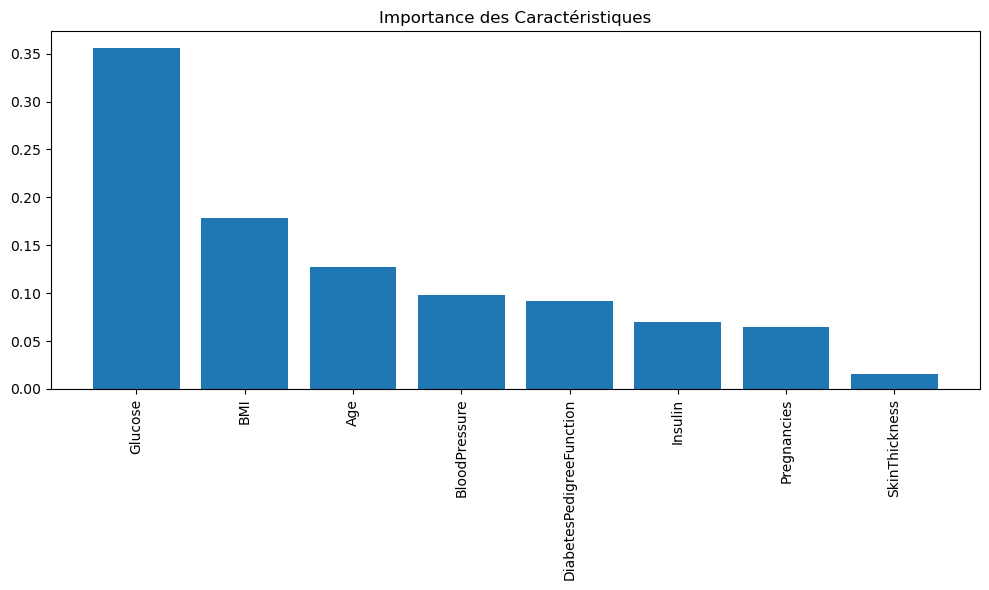

In [32]:
# Importance des caractéristiques
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Visualisation
plt.figure(figsize=(10,6))
plt.title("Importance des Caractéristiques")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

**Observation :**
- Selon l'Arbre de Décision optimisé, les caractéristiques les plus importantes sont le **Glucose**, le **BMI** et l'**Age**.
- Cela est cohérent avec les corrélations observées précédemment.

### Courbes ROC

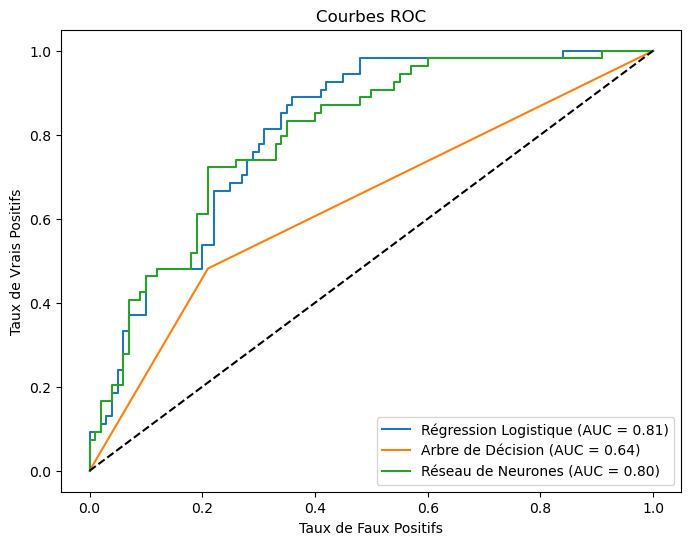

In [33]:
# Fonction pour tracer la courbe ROC
def plot_roc(y_test, y_pred_proba, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    return roc_auc

plt.figure(figsize=(8,6))

# Régression Logistique
y_pred_proba_lr = best_lr.predict_proba(X_test)[:,1]
auc_lr = plot_roc(y_test, y_pred_proba_lr, "Régression Logistique")

# Arbre de Décision
y_pred_proba_dt = best_dt.predict_proba(X_test)[:,1]
auc_dt = plot_roc(y_test, y_pred_proba_dt, "Arbre de Décision")

# Réseau de Neurones
y_pred_proba_mlp = best_mlp.predict_proba(X_test)[:,1]
auc_mlp = plot_roc(y_test, y_pred_proba_mlp, "Réseau de Neurones")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC')
plt.legend(loc='lower right')
plt.show()

**Analyse :**
- La **Régression Logistique** a la plus grande AUC (aire sous la courbe), indiquant une bonne capacité à distinguer les classes.
- Le **Réseau de Neurones** suit de près, avec une AUC légèrement inférieure.
- L'**Arbre de Décision** a l'AUC la plus faible.

## Conclusion

**Synthèse des résultats :**
- Le **Réseau de Neurones Optimisé** offre les meilleures performances globales en termes d'accuracy, de rappel et de F1-score.
- La **Régression Logistique** a la meilleure AUC, ce qui indique une bonne capacité à distinguer les classes, mais ses autres métriques sont inférieures à celles du Réseau de Neurones.
- L'**Arbre de Décision** n'a pas montré d'amélioration significative après optimisation et a les performances les plus faibles.

**Recommandation :**
- **Modèle choisi :** Réseau de Neurones Optimisé.
- **Justification :** Le rappel élevé est crucial pour détecter les patients diabétiques et minimiser les faux négatifs. De plus, le Réseau de Neurones capture mieux les relations non linéaires entre les variables.
- **Limites :** Le dataset est déséquilibré, ce qui pourrait affecter les performances. L'utilisation de techniques d'équilibrage des classes pourrait être explorée pour améliorer davantage le modèle.

## Perspectives d'Amélioration

- **Équilibrage des Classes :** Utiliser des techniques comme le suréchantillonnage (SMOTE) ou le sous-échantillonnage pour traiter le déséquilibre des classes.
- **Collecte de Données Supplémentaires :** Plus de données pourraient aider à construire un modèle plus robuste et généralisable.
- **Exploration d'Autres Modèles :** Tester des modèles avancés comme les forêts aléatoires ou les gradient boosting (e.g., XGBoost).

## Références

- Documentation Scikit-learn : https://scikit-learn.org/
- Dataset Pima Indians Diabetes Database : https://www.kaggle.com/uciml/pima-indians-diabetes-database